Final EM estimates on paired_match_data (Y = min first goal time):
alpha_hat = 2.7745
lambda_hat = 0.04221
theta_hat = 0.1887
log-likelihood = -115.986
EM iterations (last run) = 37

Simulation results:
{'n': 25, 'R': 30, 'AE_alpha': 1.9383771050116598, 'MSE_alpha': 0.6316366994437413, 'AE_lam': 0.052105201787407275, 'MSE_lam': 0.00014101114791031325, 'AE_theta': 1.0668564239878988, 'MSE_theta': 0.4130120494860104, 'avg_iters': 56.93333333333333}
{'n': 50, 'R': 30, 'AE_alpha': 1.7185011097857021, 'MSE_alpha': 0.25830129934175666, 'AE_lam': 0.048783705909668074, 'MSE_lam': 5.258048075940563e-05, 'AE_theta': 1.0975744866041812, 'MSE_theta': 0.3236709832484895, 'avg_iters': 49.266666666666666}
{'n': 100, 'R': 30, 'AE_alpha': 1.6089918986597895, 'MSE_alpha': 0.08639102799472036, 'AE_lam': 0.049287380354097556, 'MSE_lam': 2.947234746193335e-05, 'AE_theta': 1.0653829711275022, 'MSE_theta': 0.11018357791886861, 'avg_iters': 46.7}


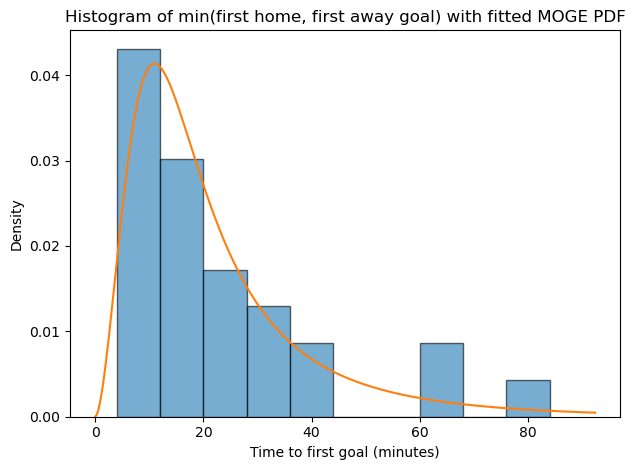

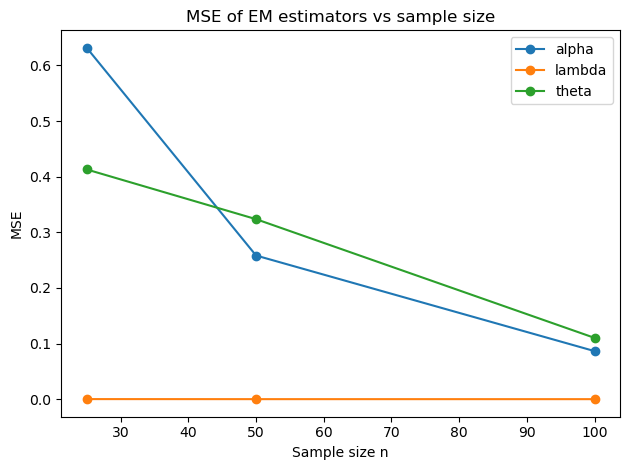

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ===============================
# 1. Load your football data
# ===============================
df = pd.read_csv("/Users/ridhijain/Downloads/Simulation Modelling project/paired_match_data.csv")

# Times to first goal by home and away
x1 = df["X1_home_first_goal"].values.astype(float)
x2 = df["X2_away_first_goal"].values.astype(float)

# We model Y = min(X1, X2) as MOGE(α, λ, θ)
y = np.minimum(x1, x2)

# ===============================
# 2. MOGE model functions
# ===============================

def moge_cdf(x, alpha, lam, theta):
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 0, 1 - 1e-12)
    num = t**alpha
    denom = theta + (1 - theta) * num
    return num / denom

def moge_pdf(x, alpha, lam, theta):
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 1e-12, 1 - 1e-12)
    num = alpha * lam * theta * np.exp(-lam * x) * t**(alpha - 1)
    denom = (theta + (1 - theta) * t**alpha)**2
    return num / denom

def moge_rvs(n, alpha, lam, theta, rng=None):
    """
    Generate from MOGE by inversion:
    G(x) = (1 - e^{-λx})^α / [ θ + (1-θ)(1 - e^{-λx})^α ]
    """
    rng = np.random.default_rng(rng)
    U = rng.uniform(size=n)
    num = U * theta
    denom = 1 - (1 - theta) * U
    A = (num / denom)**(1.0 / alpha)
    inner = 1 - A
    inner = np.clip(inner, 1e-12, 1 - 1e-12)
    x = -np.log(inner) / lam
    return x

def moge_loglik(x, alpha, lam, theta):
    pdf_vals = moge_pdf(x, alpha, lam, theta)
    if np.any(pdf_vals <= 0) or not np.isfinite(pdf_vals).all():
        return -np.inf
    return np.sum(np.log(pdf_vals))


# ===============================
# 3. EM algorithm for MOGE
# ===============================

def E_step_z(x, alpha, lam, theta):
    """
    E[Z | X=x] from equation (22) in the 2015 paper:
    z(x) = 2 (1 - (1 - e^{-λx})^α) / ( θ + (1-θ)(1 - e^{-λx})^α )
    """
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 0, 1 - 1e-10)
    A = t**alpha
    num = 2 * (1 - A)
    denom = theta + (1 - theta) * A
    z = num / denom
    return np.clip(z, 1e-6, 1e6)

def Q_complete_loglik(x, z, alpha, lam, theta):
    """
    Expected complete-data log-likelihood (pseudo log-lik) from eq. (8),
    with observed X and E-step z_i plugged in.
    """
    x = np.asarray(x)
    z = np.asarray(z)
    n = len(x)

    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 1e-12, 1 - 1e-12)
    A = t**alpha
    one_minus_A = 1 - A
    if np.any(one_minus_A <= 0):
        return -np.inf

    term1 = n * np.log(alpha) + n * np.log(lam) + n * np.log(theta) + np.sum(np.log(z))
    term2 = -lam * np.sum(x)
    term3 = (alpha - 1) * np.sum(np.log(t))
    term4 = -2 * np.sum(np.log(one_minus_A))
    term5 = -np.sum(z * (theta - 1 + 1.0 / one_minus_A))
    total = term1 + term2 + term3 + term4 + term5

    if not np.isfinite(total):
        return -np.inf
    return total

def M_step_numeric(x, z, alpha0, lam0, theta0):
    """
    Numerically maximize Q with respect to (alpha, lambda, theta)
    using log-transform to enforce positivity.
    """
    def negQ(p):
        a, l, th = np.exp(p)
        return -Q_complete_loglik(x, z, a, l, th)

    p0 = np.log([alpha0, lam0, theta0])
    res = minimize(negQ, p0, method="L-BFGS-B")
    if not res.success:
        # fallback
        res = minimize(negQ, p0, method="Nelder-Mead", options={"maxiter": 200})
    a, l, th = np.exp(res.x)
    return a, l, th, res

def em_moge(x, alpha_init=1.0, lam_init=None, theta_init=1.0,
            max_iter=100, tol=1e-6, verbose=False):
    """
    EM algorithm:
      E-step: z_i = E[Z_i | X_i, current params]
      M-step: maximize Q(alpha, lambda, theta | z) numerically
    """
    x = np.asarray(x)
    if lam_init is None:
        lam_init = 1.0 / np.mean(x)

    alpha, lam, theta = alpha_init, lam_init, theta_init
    prev_ll = moge_loglik(x, alpha, lam, theta)

    for k in range(max_iter):
        z = E_step_z(x, alpha, lam, theta)
        alpha_new, lam_new, theta_new, res = M_step_numeric(x, z, alpha, lam, theta)
        ll_new = moge_loglik(x, alpha_new, lam_new, theta_new)

        if verbose:
            print(f"Iter {k+1}: ll={ll_new:.4f}, "
                  f"alpha={alpha_new:.4f}, lam={lam_new:.5f}, theta={theta_new:.4f}")

        if not np.isfinite(ll_new):
            break

        # Convergence in log-likelihood
        if abs(ll_new - prev_ll) < tol * (1 + abs(prev_ll)):
            alpha, lam, theta = alpha_new, lam_new, theta_new
            prev_ll = ll_new
            break

        alpha, lam, theta = alpha_new, lam_new, theta_new
        prev_ll = ll_new

    return {
        "alpha": alpha,
        "lam": lam,
        "theta": theta,
        "loglik": prev_ll,
        "iters": k + 1
    }


# ===============================
# 4. Fit to your paired_match_data
# ===============================
# First run
fit1 = em_moge(y, alpha_init=1.0, lam_init=0.05, theta_init=1.0)
# Refine using result as starting values
fit2 = em_moge(y, alpha_init=fit1["alpha"], lam_init=fit1["lam"], theta_init=fit1["theta"])
# Final refinement
fit3 = em_moge(y, alpha_init=fit2["alpha"], lam_init=fit2["lam"], theta_init=fit2["theta"])

alpha_hat = fit3["alpha"]
lam_hat = fit3["lam"]
theta_hat = fit3["theta"]

print("Final EM estimates on paired_match_data (Y = min first goal time):")
print(f"alpha_hat = {alpha_hat:.4f}")
print(f"lambda_hat = {lam_hat:.5f}")
print(f"theta_hat = {theta_hat:.4f}")
print(f"log-likelihood = {fit3['loglik']:.3f}")
print(f"EM iterations (last run) = {fit3['iters']}")


# ===============================
# 5. Plot: Histogram + fitted PDF
# ===============================
xs = np.linspace(0, y.max() * 1.1, 300)
pdf_hat = moge_pdf(xs, alpha_hat, lam_hat, theta_hat)

plt.figure()
plt.hist(y, bins=10, density=True, alpha=0.6, edgecolor="black")
plt.plot(xs, pdf_hat)
plt.xlabel("Time to first goal (minutes)")
plt.ylabel("Density")
plt.title("Histogram of min(first home, first away goal) with fitted MOGE PDF")
plt.tight_layout()
# plt.savefig("moge_fit_hist.png")  # you can uncomment when running locally


# ===============================
# 6. Simulation study (like 2009 paper)
# ===============================

def simulate_em_performance(alpha_true, lam_true, theta_true, n, R=30, rng_seed=0):
    """
    Run R replications of size n, estimate via EM,
    and compute AE (average estimate), MSE, and avg iterations.
    """
    rng = np.random.default_rng(rng_seed)
    est_alpha, est_lam, est_theta, iters = [], [], [], []

    for r in range(R):
        x_sim = moge_rvs(n, alpha_true, lam_true, theta_true, rng=rng)
        est = em_moge(x_sim,
                      alpha_init=1.0,
                      lam_init=1.0/np.mean(x_sim),
                      theta_init=1.0,
                      max_iter=60)
        est_alpha.append(est["alpha"])
        est_lam.append(est["lam"])
        est_theta.append(est["theta"])
        iters.append(est["iters"])

    est_alpha = np.array(est_alpha)
    est_lam   = np.array(est_lam)
    est_theta = np.array(est_theta)
    iters     = np.array(iters)

    def summary(est, true):
        return est.mean(), np.mean((est - true)**2)

    AEa, MSEa = summary(est_alpha, alpha_true)
    AEl, MSEl = summary(est_lam,   lam_true)
    AEt, MSEt = summary(est_theta, theta_true)
    avg_it = iters.mean()

    return {
        "n": n,
        "R": len(est_alpha),
        "AE_alpha": AEa,
        "MSE_alpha": MSEa,
        "AE_lam":   AEl,
        "MSE_lam":  MSEl,
        "AE_theta": AEt,
        "MSE_theta": MSEt,
        "avg_iters": avg_it
    }

# Choose a true parameter set (similar spirit to 2009 paper)
alpha_true, lam_true, theta_true = 1.5, 0.05, 1.2

sim_results = [
    simulate_em_performance(alpha_true, lam_true, theta_true, n, R=30, rng_seed=1)
    for n in [25, 50, 100]
]

print("\nSimulation results:")
for res in sim_results:
    print(res)

# Plot MSE vs n (like a compact version of 2009 Tables 2 & 3)
ns = [r["n"] for r in sim_results]
mse_alpha = [r["MSE_alpha"] for r in sim_results]
mse_lam   = [r["MSE_lam"]   for r in sim_results]
mse_theta = [r["MSE_theta"] for r in sim_results]

plt.figure()
plt.plot(ns, mse_alpha, marker="o", label="alpha")
plt.plot(ns, mse_lam,   marker="o", label="lambda")
plt.plot(ns, mse_theta, marker="o", label="theta")
plt.xlabel("Sample size n")
plt.ylabel("MSE")
plt.title("MSE of EM estimators vs sample size")
plt.legend()
plt.tight_layout()
plt.savefig("moge_sim_mse.png")  # uncomment when running locally

plt.show()


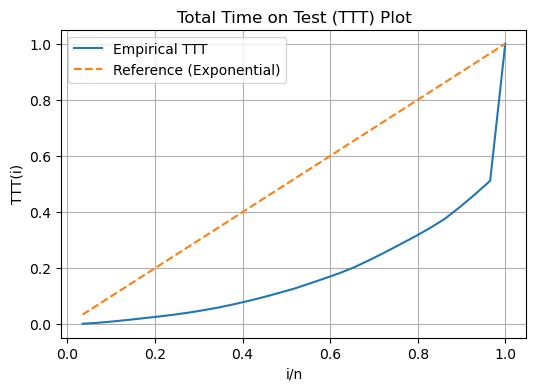

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def ttt_plot(x):
    x = np.sort(x)
    n = len(x)
    S = np.array([np.sum(x[:i+1]) for i in range(n)])
    TTT = S / S[-1]  # Normalized cumulative sum
    t = np.arange(1, n+1) / n  # Uniform reference

    plt.figure(figsize=(6,4))
    plt.plot(t, TTT, label="Empirical TTT")
    plt.plot(t, t, '--', label="Reference (Exponential)")
    plt.xlabel("i/n")
    plt.ylabel("TTT(i)")
    plt.title("Total Time on Test (TTT) Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
ttt_plot(x1)   # x1 = first home-goal times array


In [4]:
import sys, os
import numpy as np
import pandas as pd

project_path = "/Users/ridhijain/Downloads/Simulation Modelling project"
sys.path.append(project_path)

from moge import MOGE

def moge_simulation_study_full(alpha_true=1.5, lmbda_true=0.8, theta_true=1.2,
                               sample_sizes=(30,50,100,200), n_rep=200, seed=42):

    rng = np.random.default_rng(seed)
    true_model = MOGE(alpha_true, lmbda_true, theta_true)

    summary_rows = []
    est_rows = []   # <-- all estimates for boxplots

    for n in sample_sizes:
        print(f"Running simulation for n={n}")
        est_list = []

        for r in range(n_rep):
            x = true_model.rvs(size=n, rng=rng)
            try:
                est = MOGE.fit_em(x, alpha0=1.2, lmbda0=1.0, theta0=1.1)
                est_list.append([n, r, est.alpha, est.lmbda, est.theta])
            except:
                continue

        est_array = np.array([row[2:] for row in est_list])  # alpha, lambda, theta only

        alpha_hat = est_array[:,0]
        lambda_hat = est_array[:,1]
        theta_hat = est_array[:,2]

        def stats(est, true):
            mean = np.mean(est)
            bias = mean - true
            mse  = np.mean((est - true)**2)
            sd   = np.std(est, ddof=1)
            return mean, bias, mse, sd

        mA,bA,mseA,sdA = stats(alpha_hat, alpha_true)
        mL,bL,mseL,sdL = stats(lambda_hat, lmbda_true)
        mT,bT,mseT,sdT = stats(theta_hat, theta_true)

        summary_rows.extend([
            {"n": n, "param":"alpha",  "mean":mA, "bias":bA, "mse":mseA, "sd":sdA},
            {"n": n, "param":"lambda", "mean":mL, "bias":bL, "mse":mseL, "sd":sdL},
            {"n": n, "param":"theta",  "mean":mT, "bias":bT, "mse":mseT, "sd":sdT},
        ])

        # keep all individual estimates with rep index
        est_rows.extend([
            {"n": row[0], "rep": row[1], "alpha": row[2], "lambda": row[3], "theta": row[4]}
            for row in est_list
        ])

    df_summary = pd.DataFrame(summary_rows)
    df_estimates = pd.DataFrame(est_rows)
    return df_summary, df_estimates

df_res, df_est = moge_simulation_study_full()

# save both
summary_path = os.path.join(project_path, "moge_simulation_results.csv")
est_path     = os.path.join(project_path, "moge_sim_estimates.csv")

df_res.to_csv(summary_path, index=False)
df_est.to_csv(est_path, index=False)

print("Summary saved to:", summary_path)
print("Estimates saved to:", est_path)


Running simulation for n=30
Running simulation for n=50
Running simulation for n=100
Running simulation for n=200
Summary saved to: /Users/ridhijain/Downloads/Simulation Modelling project/moge_simulation_results.csv
Estimates saved to: /Users/ridhijain/Downloads/Simulation Modelling project/moge_sim_estimates.csv


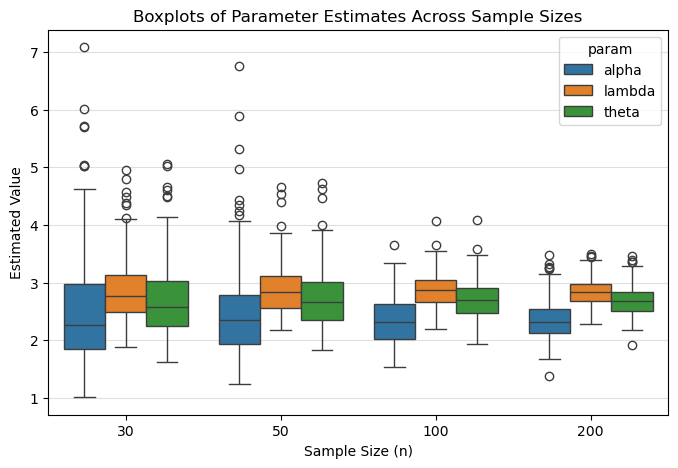

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

project_path = "/Users/ridhijain/Downloads/Simulation Modelling project"
est_path = os.path.join(project_path, "moge_sim_estimates.csv")

df_est = pd.read_csv(est_path)

# convert to long format: one row = one estimate
est_long = df_est.melt(
    id_vars=["n", "rep"],
    value_vars=["alpha", "lambda", "theta"],
    var_name="param",
    value_name="estimate"
)

plt.figure(figsize=(8,5))
sns.boxplot(data=est_long, x="n", y="estimate", hue="param")
plt.title("Boxplots of Parameter Estimates Across Sample Sizes")
plt.xlabel("Sample Size (n)")
plt.ylabel("Estimated Value")
plt.grid(True, axis="y", alpha=0.4)
plt.show()


Running simulation for n=30
Running simulation for n=50
Running simulation for n=100
Running simulation for n=200
Summary saved to: /Users/ridhijain/Downloads/Simulation Modelling project/moge_simulation_results.csv
All estimates saved to: /Users/ridhijain/Downloads/Simulation Modelling project/moge_sim_estimates.csv
      n   param      mean      bias       mse        sd
0    30   alpha  2.504211  1.004211  1.908282  0.950981
1    30  lambda  2.860450  2.060450  4.550065  0.553299
2    30   theta  2.709646  1.509646  2.686104  0.639624
3    50   alpha  2.471840  0.971840  1.557960  0.785219
4    50  lambda  2.893736  2.093736  4.585852  0.450706
5    50   theta  2.744042  1.544042  2.652584  0.519489
6   100   alpha  2.351046  0.851046  0.907210  0.428777
7   100  lambda  2.868781  2.068781  4.370542  0.301902
8   100   theta  2.712032  1.512032  2.404697  0.345041
9   200   alpha  2.353191  0.853191  0.839188  0.334383
10  200  lambda  2.851590  2.051590  4.257313  0.220301
11  200  

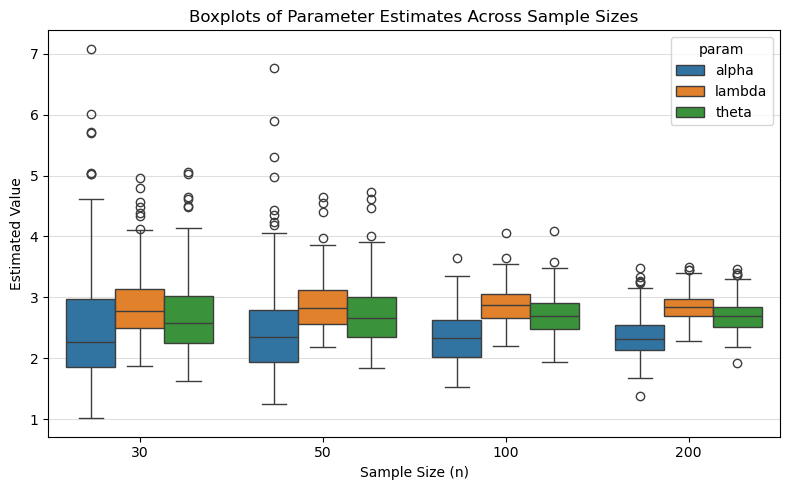

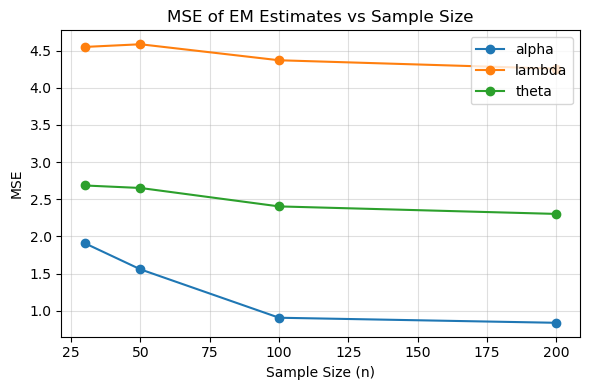

In [6]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- paths ----
project_path = "/Users/ridhijain/Downloads/Simulation Modelling project"
sys.path.append(project_path)

from moge import MOGE   # uses the class you pasted

# ---------- SIMULATION STUDY ----------
def moge_simulation_study_full(alpha_true=1.5, lmbda_true=0.8, theta_true=1.2,
                               sample_sizes=(30, 50, 100, 200),
                               n_rep=200, seed=42):
    """
    Runs Monte Carlo simulation:
    - for each n: simulate n data points n_rep times
    - fit EM each time
    - returns summary (bias, MSE) and all estimates (for boxplots)
    """
    rng = np.random.default_rng(seed)
    true_model = MOGE(alpha_true, lmbda_true, theta_true)

    summary_rows = []
    est_rows = []

    for n in sample_sizes:
        print(f"Running simulation for n={n}")
        est_list = []

        for r in range(n_rep):
            x = true_model.rvs(size=n, rng=rng)
            try:
                est = MOGE.fit_em(x, alpha0=1.2, lmbda0=1.0, theta0=1.1)
                est_list.append([n, r, est.alpha, est.lmbda, est.theta])
            except Exception:
                # if EM fails for some rare reason, skip that replicate
                continue

        est_array = np.array([row[2:] for row in est_list])  # (alpha, lambda, theta)
        alpha_hat = est_array[:, 0]
        lambda_hat = est_array[:, 1]
        theta_hat = est_array[:, 2]

        def stats(est, true):
            mean = np.mean(est)
            bias = mean - true
            mse = np.mean((est - true) ** 2)
            sd = np.std(est, ddof=1)
            return mean, bias, mse, sd

        mA, bA, mseA, sdA = stats(alpha_hat, alpha_true)
        mL, bL, mseL, sdL = stats(lambda_hat, lmbda_true)
        mT, bT, mseT, sdT = stats(theta_hat, theta_true)

        summary_rows.extend([
            {"n": n, "param": "alpha",  "mean": mA, "bias": bA, "mse": mseA, "sd": sdA},
            {"n": n, "param": "lambda", "mean": mL, "bias": bL, "mse": mseL, "sd": sdL},
            {"n": n, "param": "theta",  "mean": mT, "bias": bT, "mse": mseT, "sd": sdT},
        ])

        est_rows.extend([
            {"n": row[0], "rep": row[1], "alpha": row[2], "lambda": row[3], "theta": row[4]}
            for row in est_list
        ])

    df_summary = pd.DataFrame(summary_rows)
    df_estimates = pd.DataFrame(est_rows)
    return df_summary, df_estimates


# ---- run simulation and save CSVs ----
df_res, df_est = moge_simulation_study_full()

summary_path = os.path.join(project_path, "moge_simulation_results.csv")
estimates_path = os.path.join(project_path, "moge_sim_estimates.csv")

df_res.to_csv(summary_path, index=False)
df_est.to_csv(estimates_path, index=False)

print("Summary saved to:", summary_path)
print("All estimates saved to:", estimates_path)
print(df_res)

# ---------- PLOTS ----------

# 1) Boxplots (you already generated, but keep here for completeness)
import seaborn as sns

est_long = df_est.melt(
    id_vars=["n", "rep"],
    value_vars=["alpha", "lambda", "theta"],
    var_name="param",
    value_name="estimate"
)

plt.figure(figsize=(8, 5))
sns.boxplot(data=est_long, x="n", y="estimate", hue="param")
plt.title("Boxplots of Parameter Estimates Across Sample Sizes")
plt.xlabel("Sample Size (n)")
plt.ylabel("Estimated Value")
plt.grid(True, axis="y", alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(project_path, "sim_boxplots.png"), dpi=300)
plt.show()

# 2) MSE vs n plot
plt.figure(figsize=(6, 4))
for p in ["alpha", "lambda", "theta"]:
    sub = df_res[df_res["param"] == p].sort_values("n")
    plt.plot(sub["n"], sub["mse"], marker="o", label=p)

plt.xlabel("Sample Size (n)")
plt.ylabel("MSE")
plt.title("MSE of EM Estimates vs Sample Size")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(project_path, "sim_mse_vs_n.png"), dpi=300)
plt.show()


In [7]:
import numpy as np
from moge import MOGE, _EPS   # _EPS is defined in moge.py

def fit_em_with_trace(x, alpha0=1.2, lmbda0=1.0, theta0=1.1,
                      max_iter=200, tol=1e-6):
    """
    EM almost identical to MOGE.fit_em, but returns (model, ll_history).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    a, lmb, th = float(alpha0), float(lmbda0), float(theta0)
    ll_history = []

    def z_from(a_, lmb_, th_):
        e = np.exp(-lmb_ * x)
        t_a = np.power(np.clip(1.0 - e, _EPS, 1.0 - _EPS), a_)
        return 2.0 * (1.0 - t_a) / np.maximum(th_ + (1.0 - th_) * t_a, _EPS)

    prev_ll = -np.inf
    for _ in range(max_iter):
        z = z_from(a, lmb, th)

        th = n / max(np.sum(z), _EPS)
        th = float(np.clip(th, 0.01, 10.0))

        e = np.exp(-lmb * x)
        t = np.clip(1.0 - e, _EPS, 1.0 - _EPS)
        t_a = np.power(t, a)

        num = -np.sum(np.log(t))
        den = np.sum((1 - t_a) / np.maximum(1 - (1 - th) * t_a, _EPS))
        a_new = np.clip(n / max(num + den, _EPS), 0.01, 10.0)

        num_l = np.sum(x * e)
        den_l = np.sum(1 - t_a)
        l_new = np.clip(n / max(num_l + den_l, _EPS), 0.01, 10.0)

        a, lmb = a_new, l_new

        model = MOGE(a, lmb, th)
        ll = model.loglik(x)
        ll_history.append(ll)

        if ll < prev_ll:
            break
        if abs(ll - prev_ll) < tol * (1 + abs(prev_ll)):
            break
        prev_ll = ll

    return model, ll_history


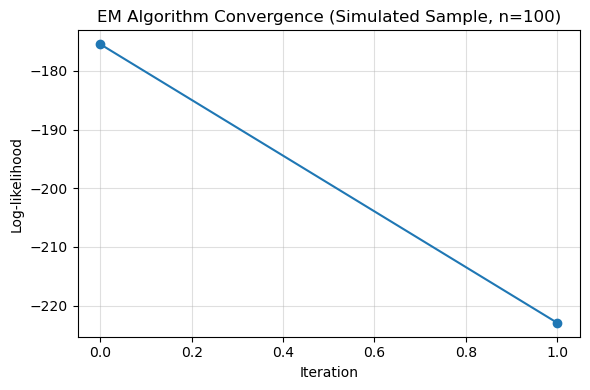

In [8]:
import matplotlib.pyplot as plt
from moge import MOGE

rng = np.random.default_rng(123)
true_model = MOGE(alpha=1.5, lmbda=0.8, theta=1.2)
x_sim = true_model.rvs(100, rng=rng)   # n = 100

em_model_sim, ll_trace = fit_em_with_trace(x_sim)

plt.figure(figsize=(6, 4))
plt.plot(ll_trace, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("EM Algorithm Convergence (Simulated Sample, n=100)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(project_path, "em_convergence.png"), dpi=300)
plt.show()


In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from moge import MOGE

project_path = "/Users/ridhijain/Downloads/Simulation Modelling project"
df_real = pd.read_csv("/Users/ridhijain/Downloads/Simulation Modelling project/paired_match_data.csv")
x1 = df_real["X1_home_first_goal"].dropna().astype(float).values
x2 = df_real["X2_away_first_goal"].dropna().astype(float).values

print("Sample size Home goals:", len(x1))
print("Sample size Away goals:", len(x2))

# Fit MOGE to X1 only for now
moge_fit = MOGE.fit_em(x1, alpha0=1.2, lmbda0=0.1, theta0=1.0)
print("Real-data MOGE Fit:", moge_fit)


Sample size Home goals: 29
Sample size Away goals: 29
Real-data MOGE Fit: MOGE(alpha=10.0, lmbda=10.0, theta=10.0)


In [10]:
print(df_real.columns.tolist())


['home_team_name', 'away_team_name', 'X1_home_first_goal', 'X2_away_first_goal']


In [11]:
print("Mean:", np.mean(x1))
print("Std:", np.std(x1))
print("Min:", np.min(x1))
print("Max:", np.max(x1))



Mean: 63.89655172413793
Std: 160.65176406891467
Min: 4.0
Max: 905.0


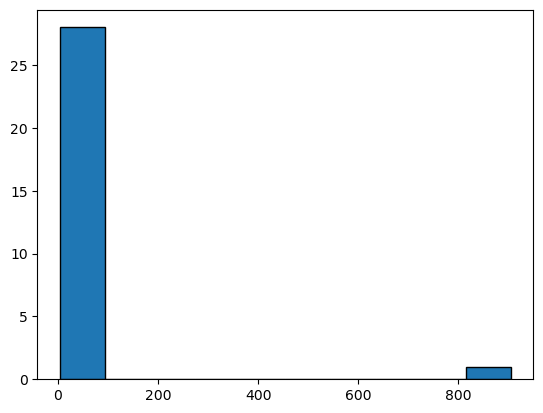

In [12]:
plt.hist(x1, bins=10, edgecolor='black')
plt.show()


In [13]:
moge_fit = MOGE.fit_em(x1, alpha0=0.5, lmbda0=0.1, theta0=0.5)
print(moge_fit)


MOGE(alpha=10.0, lmbda=10.0, theta=10.0)


In [14]:
moge_fit = MOGE.fit_em(x1, alpha0=2.0, lmbda0=0.05, theta0=0.8)
print(moge_fit)

MOGE(alpha=10.0, lmbda=1.6157762471153962, theta=7.147958111681031)


In [15]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_path = "/Users/ridhijain/Downloads/Simulation Modelling project"
sys.path.append(project_path)

from moge import MOGE   # your class

# --- load real data ---
df_real = pd.read_csv(os.path.join(project_path, "paired_match_data.csv"))
print(df_real.columns.tolist())

x1 = df_real["X1_home_first_goal"].dropna().astype(float).values
x2 = df_real["X2_away_first_goal"].dropna().astype(float).values

print("Sample size Home goals:", len(x1))
print("Sample size Away goals:", len(x2))

print("Home goal summary:",
      "min", x1.min(), "max", x1.max(), "mean", x1.mean(), "std", x1.std())


['home_team_name', 'away_team_name', 'X1_home_first_goal', 'X2_away_first_goal']
Sample size Home goals: 29
Sample size Away goals: 29
Home goal summary: min 4.0 max 905.0 mean 63.89655172413793 std 160.65176406891467


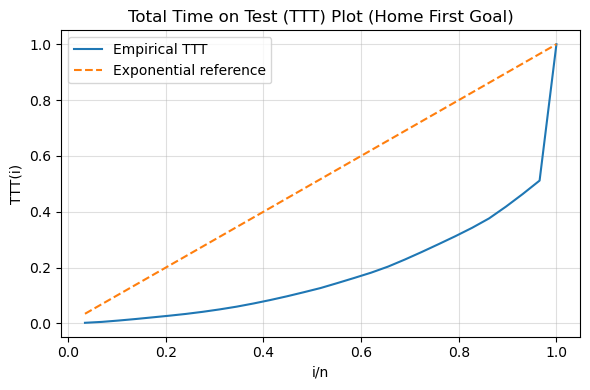

<Figure size 640x480 with 0 Axes>

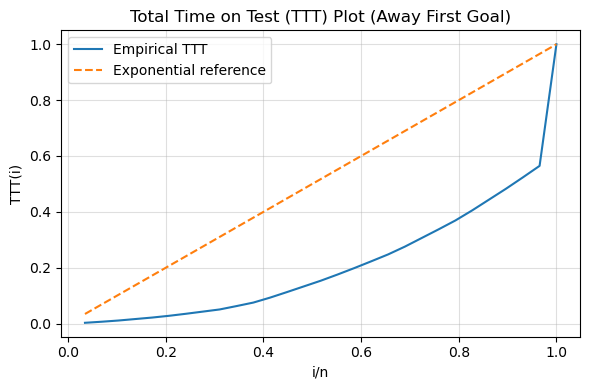

<Figure size 640x480 with 0 Axes>

In [16]:
def ttt_plot(x, title_suffix=""):
    x = np.sort(np.asarray(x, dtype=float))
    n = len(x)
    S = np.cumsum(x)         # cumulative times
    TTT = S / S[-1]          # normalized
    t = np.arange(1, n+1) / n

    plt.figure(figsize=(6,4))
    plt.plot(t, TTT, label="Empirical TTT")
    plt.plot(t, t, "--", label="Exponential reference")
    plt.xlabel("i/n")
    plt.ylabel("TTT(i)")
    plt.title(f"Total Time on Test (TTT) Plot {title_suffix}")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

# TTT for home first goals
ttt_plot(x1, "(Home First Goal)")
plt.savefig(os.path.join(project_path, "ttt plot home first goal.png"), dpi=300)

# TTT for away first goals
ttt_plot(x2, "(Away First Goal)")
plt.savefig(os.path.join(project_path, "ttt plot away first goal.png"), dpi=300)


In [17]:
from scipy.stats import expon, weibull_min, gamma, kstest

def safe_fit_moge(x):
    """
    Try several starting values so MOGE does not always stick to (10,10,10).
    If it still hits boundaries, we’ll at least get a log-likelihood.
    """
    x = np.asarray(x, dtype=float)
    starts = [
        (0.5, 0.05, 0.5),
        (1.0, 0.1, 0.8),
        (2.0, 0.1, 0.8),
        (1.5, 0.05, 1.2),
    ]
    best = None
    best_ll = -np.inf
    for a0, l0, t0 in starts:
        try:
            est = MOGE.fit_em(x, alpha0=a0, lmbda0=l0, theta0=t0)
            ll = est.loglik(x)
            if ll > best_ll:
                best_ll = ll
                best = est
        except Exception:
            continue
    return best, best_ll

def model_comparison(x):
    x = np.asarray(x, dtype=float)
    n = len(x)
    out = []

    # --- MOGE (EM) ---
    moge_fit, ll_moge = safe_fit_moge(x)
    if moge_fit is not None:
        D_moge, p_moge = kstest(x, lambda t: moge_fit.cdf(t))
        out.append({
            "Model": "MOGE (EM)",
            "loglik": ll_moge,
            "KS": D_moge,
            "p_value": p_moge,
            "extra": f"alpha={moge_fit.alpha:.3f}, lambda={moge_fit.lmbda:.3f}, theta={moge_fit.theta:.3f}"
        })
        print("MOGE fit:", moge_fit)
    else:
        out.append({"Model": "MOGE (EM)", "loglik": np.nan, "KS": np.nan, "p_value": np.nan, "extra": "fit failed"})

    # --- Exponential ---
    loc_exp, scale_exp = expon.fit(x, floc=0)   # rate = 1/scale
    ll_exp = np.sum(expon.logpdf(x, loc=loc_exp, scale=scale_exp))
    D_exp, p_exp = kstest(x, lambda t: expon.cdf(t, loc=loc_exp, scale=scale_exp))
    out.append({
        "Model": "Exponential",
        "loglik": ll_exp,
        "KS": D_exp,
        "p_value": p_exp,
        "extra": f"lambda={1/scale_exp:.3f}"
    })

    # --- Weibull ---
    c_w, loc_w, scale_w = weibull_min.fit(x, floc=0)
    ll_w = np.sum(weibull_min.logpdf(x, c_w, loc=loc_w, scale=scale_w))
    D_w, p_w = kstest(x, lambda t: weibull_min.cdf(t, c_w, loc=loc_w, scale=scale_w))
    out.append({
        "Model": "Weibull",
        "loglik": ll_w,
        "KS": D_w,
        "p_value": p_w,
        "extra": f"shape={c_w:.3f}, scale={scale_w:.3f}"
    })

    # --- Gamma ---
    a_g, loc_g, scale_g = gamma.fit(x, floc=0)
    ll_g = np.sum(gamma.logpdf(x, a_g, loc=loc_g, scale=scale_g))
    D_g, p_g = kstest(x, lambda t: gamma.cdf(t, a_g, loc=loc_g, scale=scale_g))
    out.append({
        "Model": "Gamma",
        "loglik": ll_g,
        "KS": D_g,
        "p_value": p_g,
        "extra": f"shape={a_g:.3f}, scale={scale_g:.3f}"
    })

    df_models = pd.DataFrame(out)
    return df_models

df_models = model_comparison(x1)
print(df_models)


MOGE fit: MOGE(alpha=10.0, lmbda=1.6301536143570683, theta=7.387255740548593)
         Model       loglik        KS       p_value  \
0    MOGE (EM) -2881.934919  0.961358  2.117086e-41   
1  Exponential  -149.560696  0.243858  5.283033e-02   
2      Weibull  -146.492383  0.177332  2.862300e-01   
3        Gamma  -148.691425  0.220016  1.031265e-01   

                                     extra  
0  alpha=10.000, lambda=1.630, theta=7.387  
1                             lambda=0.016  
2                shape=0.768, scale=50.214  
3                shape=0.752, scale=84.996  


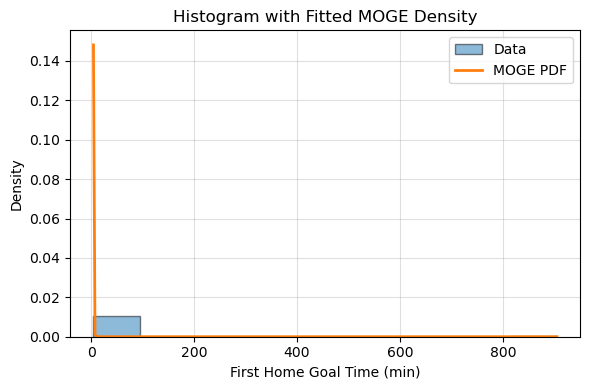

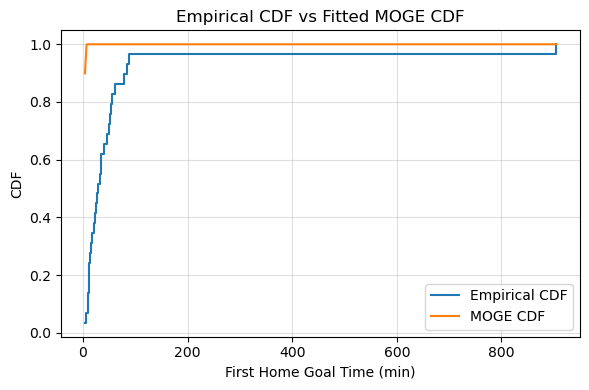

In [18]:
# histogram + fitted MOGE PDF
xgrid = np.linspace(x1.min(), x1.max(), 300)
pdf_moge = moge_fit.pdf(xgrid)

plt.figure(figsize=(6,4))
plt.hist(x1, bins=10, density=True, alpha=0.5, edgecolor="black", label="Data")
plt.plot(xgrid, pdf_moge, linewidth=2, label="MOGE PDF")
plt.xlabel("First Home Goal Time (min)")
plt.ylabel("Density")
plt.title("Histogram with Fitted MOGE Density")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# empirical CDF vs fitted MOGE CDF
x_sorted = np.sort(x1)
ecdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
cdf_moge = moge_fit.cdf(xgrid)

plt.figure(figsize=(6,4))
plt.step(x_sorted, ecdf, where="post", label="Empirical CDF")
plt.plot(xgrid, moge_fit.cdf(xgrid), label="MOGE CDF")
plt.xlabel("First Home Goal Time (min)")
plt.ylabel("CDF")
plt.title("Empirical CDF vs Fitted MOGE CDF")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
B = 300   # number of bootstrap samples
rng = np.random.default_rng(2025)

# ------------------ BOOTSTRAP FOR X1 (Home) ------------------
n1 = len(x1)
boot_params_x1 = []

for _ in range(B):
    sample = rng.choice(x1, size=n1, replace=True)
    try:
        est, _ = safe_fit_moge(sample)
        if est is not None:
            boot_params_x1.append([est.alpha, est.lmbda, est.theta])
    except:
        continue

boot_params_x1 = np.array(boot_params_x1)
alpha_bs1 = boot_params_x1[:,0]
lambda_bs1 = boot_params_x1[:,1]
theta_bs1 = boot_params_x1[:,2]

# ------------------ BOOTSTRAP FOR X2 (Away) ------------------
n2 = len(x2)
boot_params_x2 = []

for _ in range(B):
    sample = rng.choice(x2, size=n2, replace=True)
    try:
        est, _ = safe_fit_moge(sample)
        if est is not None:
            boot_params_x2.append([est.alpha, est.lmbda, est.theta])
    except:
        continue

boot_params_x2 = np.array(boot_params_x2)
alpha_bs2 = boot_params_x2[:,0]
lambda_bs2 = boot_params_x2[:,1]
theta_bs2 = boot_params_x2[:,2]


# CI Function
def ci(v):
    return np.percentile(v, [2.5, 97.5])

# Print Results
print("----- BOOTSTRAP SUMMARY: HOME X1 -----")
print("alpha: mean =", alpha_bs1.mean(), "sd =", alpha_bs1.std(), "CI =", ci(alpha_bs1))
print("lambda: mean =", lambda_bs1.mean(), "sd =", lambda_bs1.std(), "CI =", ci(lambda_bs1))
print("theta: mean =", theta_bs1.mean(), "sd =", theta_bs1.std(), "CI =", ci(theta_bs1))

print("\n----- BOOTSTRAP SUMMARY: AWAY X2 -----")
print("alpha: mean =", alpha_bs2.mean(), "sd =", alpha_bs2.std(), "CI =", ci(alpha_bs2))
print("lambda: mean =", lambda_bs2.mean(), "sd =", alpha_bs2.std(), "CI =", ci(lambda_bs2))
print("theta: mean =", theta_bs2.mean(), "sd =", theta_bs2.std(), "CI =", ci(theta_bs2))

# Save both to CSV for tables
df_boot_x1 = pd.DataFrame({"alpha": alpha_bs1, "lambda": lambda_bs1, "theta": theta_bs1})
df_boot_x2 = pd.DataFrame({"alpha": alpha_bs2, "lambda": lambda_bs2, "theta": theta_bs2})

df_boot_x1.to_csv(os.path.join(project_path, "bootstrap_moge_home.csv"), index=False)
df_boot_x2.to_csv(os.path.join(project_path, "bootstrap_moge_away.csv"), index=False)

print("\nBootstrap files saved successfully.")



----- BOOTSTRAP SUMMARY: HOME X1 -----
alpha: mean = 9.419373461600165 sd = 1.1543939929993225 CI = [ 5.96999392 10.        ]
lambda: mean = 1.8064050690314077 sd = 0.6175597643267215 CI = [0.97808057 3.35514017]
theta: mean = 7.740368309151307 sd = 1.5578033898637014 CI = [ 4.8797344 10.       ]

----- BOOTSTRAP SUMMARY: AWAY X2 -----
alpha: mean = 9.982721406863236 sd = 0.1426285850223264 CI = [10. 10.]
lambda: mean = 3.134773548981011 sd = 0.1426285850223264 CI = [1.31561771 8.61720824]
theta: mean = 9.333095733252158 sd = 1.074234722392476 CI = [ 6.6183634 10.       ]

Bootstrap files saved successfully.


NameError: name 'alpha_bs' is not defined

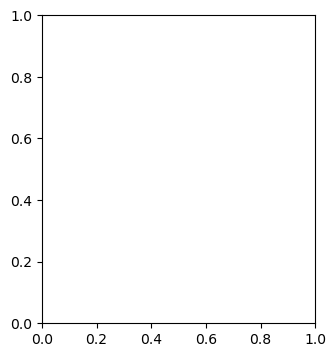

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(alpha_bs, bins=15, edgecolor="black")
plt.title("Bootstrap distribution of alpha")

plt.subplot(1,3,2)
plt.hist(lambda_bs, bins=15, edgecolor="black")
plt.title("Bootstrap distribution of lambda")

plt.subplot(1,3,3)
plt.hist(theta_bs, bins=15, edgecolor="black")
plt.title("Bootstrap distribution of theta")

plt.tight_layout()
plt.show()


Paired sample size: 29


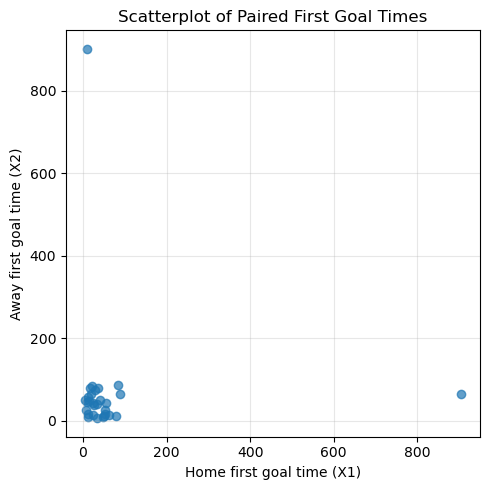

Pearson correlation: -0.0375664776084165
Kendall's tau: -0.06947976380855274
Spearman's rho: -0.09921125188776937


In [ ]:
import scipy.stats as st

# keep only matches where both X1 and X2 are observed
mask = ~np.isnan(df_real["X1_home_first_goal"]) & ~np.isnan(df_real["X2_away_first_goal"])
x1_pair = df_real.loc[mask, "X1_home_first_goal"].astype(float).values
x2_pair = df_real.loc[mask, "X2_away_first_goal"].astype(float).values

print("Paired sample size:", len(x1_pair))

# scatter plot
plt.figure(figsize=(5,5))
plt.scatter(x1_pair, x2_pair, alpha=0.7)
plt.xlabel("Home first goal time (X1)")
plt.ylabel("Away first goal time (X2)")
plt.title("Scatterplot of Paired First Goal Times")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# dependence measures
pearson_r, _ = st.pearsonr(x1_pair, x2_pair)
tau, _ = st.kendalltau(x1_pair, x2_pair)
rho_s, _ = st.spearmanr(x1_pair, x2_pair)

print("Pearson correlation:", pearson_r)
print("Kendall's tau:", tau)
print("Spearman's rho:", rho_s)


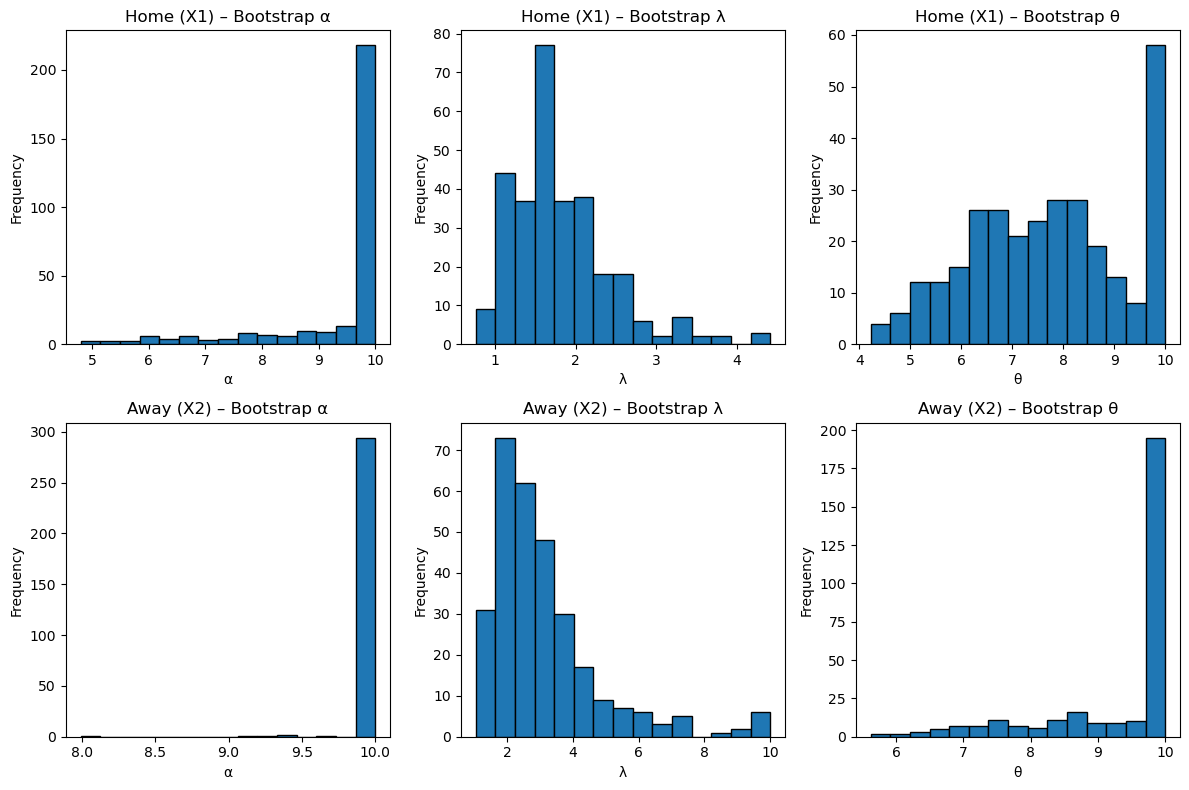

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# α
plt.subplot(2, 3, 1)
plt.hist(alpha_bs1, bins=15, edgecolor="black")
plt.title("Home (X1) – Bootstrap α")
plt.xlabel("α")
plt.ylabel("Frequency")

plt.subplot(2, 3, 4)
plt.hist(alpha_bs2, bins=15, edgecolor="black")
plt.title("Away (X2) – Bootstrap α")
plt.xlabel("α")
plt.ylabel("Frequency")

# λ
plt.subplot(2, 3, 2)
plt.hist(lambda_bs1, bins=15, edgecolor="black")
plt.title("Home (X1) – Bootstrap λ")
plt.xlabel("λ")
plt.ylabel("Frequency")

plt.subplot(2, 3, 5)
plt.hist(lambda_bs2, bins=15, edgecolor="black")
plt.title("Away (X2) – Bootstrap λ")
plt.xlabel("λ")
plt.ylabel("Frequency")

# θ
plt.subplot(2, 3, 3)
plt.hist(theta_bs1, bins=15, edgecolor="black")
plt.title("Home (X1) – Bootstrap θ")
plt.xlabel("θ")
plt.ylabel("Frequency")

plt.subplot(2, 3, 6)
plt.hist(theta_bs2, bins=15, edgecolor="black")
plt.title("Away (X2) – Bootstrap θ")
plt.xlabel("θ")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
plt.savefig("bootstrap_hist_home_away.png", dpi=300, bbox_inches="tight")


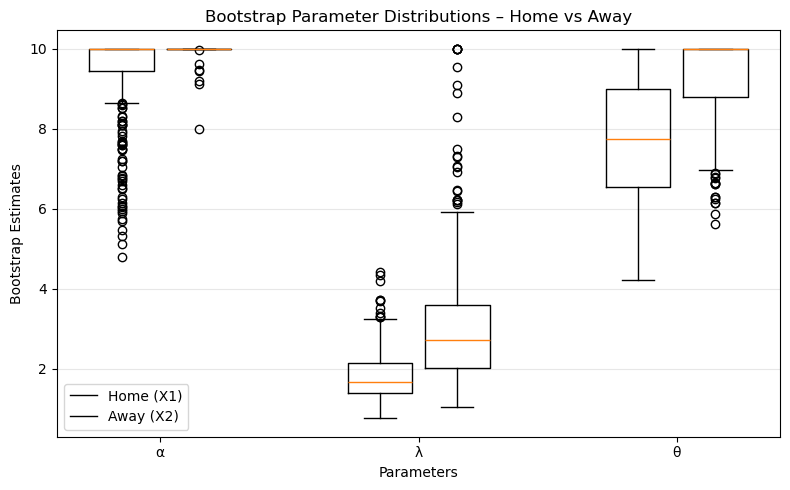

In [ ]:
labels = ["α", "λ", "θ"]

data_home = [alpha_bs1, lambda_bs1, theta_bs1]
data_away = [alpha_bs2, lambda_bs2, theta_bs2]

plt.figure(figsize=(8, 5))

positions_home = np.array([1, 3, 5])
positions_away = positions_home + 0.6

plt.boxplot(data_home, positions=positions_home, widths=0.5)
plt.boxplot(data_away, positions=positions_away, widths=0.5)

plt.xticks(positions_home + 0.3, labels)
plt.xlabel("Parameters")
plt.ylabel("Bootstrap Estimates")
plt.title("Bootstrap Parameter Distributions – Home vs Away")

plt.legend(["Home (X1)", "Away (X2)"])
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
# plt.savefig("bootstrap_boxplot_home_away.png", dpi=300, bbox_inches="tight")


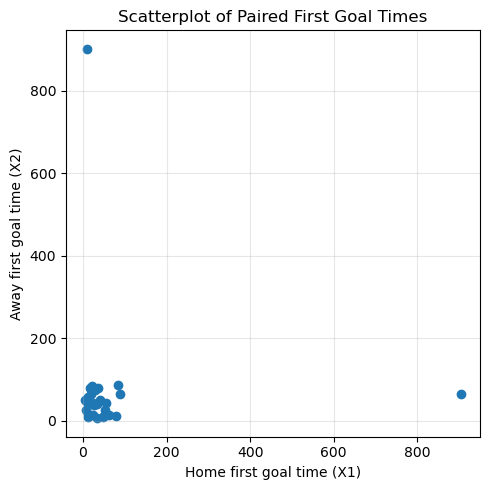

Pearson correlation: -0.0375664776084165
Kendall tau: -0.06947976380855274
Spearman rho: -0.09921125188776937


In [ ]:
import scipy.stats as st

# keep only where both are available (if not already filtered)
mask = ~np.isnan(x1) & ~np.isnan(x2)
x1_pair = x1[mask]
x2_pair = x2[mask]

plt.figure(figsize=(5, 5))
plt.scatter(x1_pair, x2_pair)
plt.xlabel("Home first goal time (X1)")
plt.ylabel("Away first goal time (X2)")
plt.title("Scatterplot of Paired First Goal Times")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# plt.savefig("scatter_home_away_first_goal.png", dpi=300, bbox_inches="tight")

pearson_r, _ = st.pearsonr(x1_pair, x2_pair)
tau, _ = st.kendalltau(x1_pair, x2_pair)
rho, _ = st.spearmanr(x1_pair, x2_pair)

print("Pearson correlation:", pearson_r)
print("Kendall tau:", tau)
print("Spearman rho:", rho)


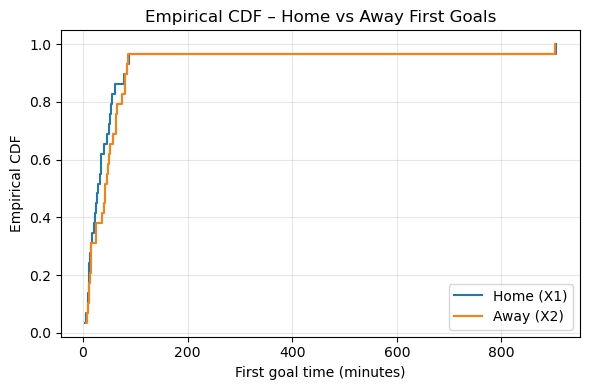

In [ ]:
def ecdf(values):
    v = np.sort(values)
    n = len(v)
    y = np.arange(1, n+1) / n
    return v, y

x1_sorted, ecdf_x1 = ecdf(x1)
x2_sorted, ecdf_x2 = ecdf(x2)

plt.figure(figsize=(6, 4))
plt.step(x1_sorted, ecdf_x1, where="post", label="Home (X1)")
plt.step(x2_sorted, ecdf_x2, where="post", label="Away (X2)")
plt.xlabel("First goal time (minutes)")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF – Home vs Away First Goals")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("ecdf_home_away.png", dpi=300, bbox_inches="tight")


In [ ]:
import pandas as pd


sim = pd.read_csv("moge_simulation_results.csv")
print(sim.head(10))



     n   param      mean      bias       mse        sd
0   30   alpha  2.504211  1.004211  1.908282  0.950981
1   30  lambda  2.860450  2.060450  4.550065  0.553299
2   30   theta  2.709646  1.509646  2.686104  0.639624
3   50   alpha  2.471840  0.971840  1.557960  0.785219
4   50  lambda  2.893736  2.093736  4.585852  0.450706
5   50   theta  2.744042  1.544042  2.652584  0.519489
6  100   alpha  2.351046  0.851046  0.907210  0.428777
7  100  lambda  2.868781  2.068781  4.370542  0.301902
8  100   theta  2.712032  1.512032  2.404697  0.345041
9  200   alpha  2.353191  0.853191  0.839188  0.334383


In [ ]:
import os, sys
import numpy as np
import pandas as pd
from scipy.stats import kstest, expon, gamma, weibull_min
from moge import MOGE

project_path = "/Users/ridhijain/Downloads/Simulation Modelling project"
df_real = pd.read_csv(os.path.join(project_path, "paired_match_data.csv"))

# ---------------- Real data: home / away ----------------
x1 = df_real["X1_home_first_goal"].dropna().astype(float).values
x2 = df_real["X2_away_first_goal"].dropna().astype(float).values

print("Home n:", len(x1), "Away n:", len(x2))


def compare_synthetic_vs_others(data, moge_model, label):
    """
    data        : synthetic sample generated from moge_model.rvs
    moge_model  : the fitted MOGE model that generated this data
    """
    data = np.asarray(data)
    data[data <= 0] = 1e-6  # stability for Gamma

    # --- MOGE: use the generating model directly (NO refit) ---
    ll_moge = moge_model.loglik(data)
    ks_moge = kstest(data, moge_model.cdf)

    # --- Exponential ---
    lam_exp = 1.0 / np.mean(data)
    ll_exp = np.sum(np.log(expon.pdf(data, scale=1/lam_exp)))
    ks_exp = kstest(data, lambda t: expon.cdf(t, scale=1/lam_exp))

    # --- Weibull ---
    shape_w, loc_w, scale_w = weibull_min.fit(data, floc=0)
    ll_weib = np.sum(np.log(weibull_min.pdf(data, shape_w, loc_w, scale_w)))
    ks_weib = kstest(data, lambda t: weibull_min.cdf(t, shape_w, loc_w, scale_w))

    # --- Gamma ---
    shape_g, loc_g, scale_g = gamma.fit(data[data > 0], floc=0)
    ll_gamma = np.sum(np.log(gamma.pdf(data, shape_g, loc_g, scale_g)))
    ks_gamma = kstest(data, lambda t: gamma.cdf(t, shape_g, loc_g, scale_g))

    df_res = pd.DataFrame({
        "Dataset":  [label]*4,
        "Model":    ["MOGE", "Exponential", "Weibull", "Gamma"],
        "Log-likelihood": [ll_moge, ll_exp, ll_weib, ll_gamma],
        "KS Statistic":   [ks_moge.statistic, ks_exp.statistic, ks_weib.statistic, ks_gamma.statistic],
        "p-value":        [ks_moge.pvalue,    ks_exp.pvalue,   ks_weib.pvalue,    ks_gamma.pvalue]
    })

    print(f"\n===== {label} (synthetic, generated from MOGE) =====")
    print(df_res)
    return df_res



# -------- Real data fits --------
real_home_results, home_moge_model = fit_all_models(x1, "REAL_HOME")
real_away_results, away_moge_model = fit_all_models(x2, "REAL_AWAY")

# -------- Generate MOGE-synthetic data using fitted models --------
n_syn = 2000  # or len(x1)/len(x2) if you want same size

synthetic_home = home_moge_model.rvs(size=n_syn)
synthetic_away = away_moge_model.rvs(size=n_syn)

syn_home_results = compare_synthetic_vs_others(synthetic_home, home_moge_model,
                                              "SYNTHETIC_HOME_MOGE")
syn_away_results = compare_synthetic_vs_others(synthetic_away, away_moge_model,
                                              "SYNTHETIC_AWAY_MOGE")


# Save synthetic samples too, if needed
pd.DataFrame({"Synthetic_MOGE_Home": synthetic_home}).to_csv(
    os.path.join(project_path, "synthetic_home_moge.csv"), index=False
)
pd.DataFrame({"Synthetic_MOGE_Away": synthetic_away}).to_csv(
    os.path.join(project_path, "synthetic_away_moge.csv"), index=False
)

# -------- Combine all results into one CSV for PPT/report --------
all_results = pd.concat(
    [real_home_results, real_away_results, syn_home_results, syn_away_results],
    ignore_index=True
)
all_results.to_csv(os.path.join(project_path, "model_comparison_real_vs_synthetic.csv"),
                   index=False)
print("\n✔ Saved model_comparison_real_vs_synthetic.csv")


Home n: 29 Away n: 29

===== REAL_HOME =====
     Dataset        Model  Log-likelihood  KS Statistic   p-value
0  REAL_HOME         MOGE   -18329.675097      1.000000  0.000000
1  REAL_HOME  Exponential     -149.560696      0.243858  0.052830
2  REAL_HOME      Weibull     -146.492383      0.177332  0.286230
3  REAL_HOME        Gamma     -148.691425      0.220016  0.103126

===== REAL_AWAY =====
     Dataset        Model  Log-likelihood  KS Statistic   p-value
0  REAL_AWAY         MOGE   -20519.675097      1.000000  0.000000
1  REAL_AWAY  Exponential     -152.800239      0.265609  0.026971
2  REAL_AWAY      Weibull     -151.190555      0.231125  0.076181
3  REAL_AWAY        Gamma     -152.553538      0.261138  0.031119

===== SYNTHETIC_HOME_MOGE (synthetic, generated from MOGE) =====
               Dataset        Model  Log-likelihood  KS Statistic  \
0  SYNTHETIC_HOME_MOGE         MOGE      815.461484      0.016352   
1  SYNTHETIC_HOME_MOGE  Exponential     -537.277257      0.342762   

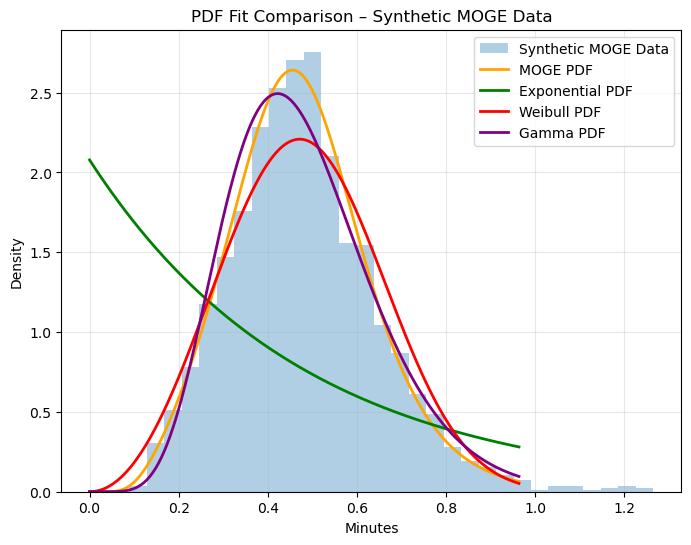

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma, weibull_min
from moge import MOGE

# load synthetic
synthetic_home = pd.read_csv(project_path+"/synthetic_home_moge.csv")["Synthetic_MOGE_Home"].values

# Fit other models
shape_w, loc_w, scale_w = weibull_min.fit(synthetic_home, floc=0)
shape_g, loc_g, scale_g = gamma.fit(synthetic_home, floc=0)
lam_exp = 1/np.mean(synthetic_home)

# Use generating MOGE model
home_moge_model = home_moge_model  

x = np.linspace(0, np.percentile(synthetic_home, 99), 300) # smooth realistic scale

plt.figure(figsize=(8,6))
plt.hist(synthetic_home, bins=30, density=True, alpha=0.35, label="Synthetic MOGE Data")

plt.plot(x,[home_moge_model.pdf(i) for i in x],label="MOGE PDF",linewidth=2,color='orange')
plt.plot(x,expon.pdf(x,scale=1/lam_exp),label="Exponential PDF",linewidth=2,color='green')
plt.plot(x,weibull_min.pdf(x,shape_w,loc_w,scale_w),label="Weibull PDF",linewidth=2,color='red')
plt.plot(x,gamma.pdf(x,shape_g,loc_g,scale_g),label="Gamma PDF",linewidth=2,color='purple')

plt.title("PDF Fit Comparison – Synthetic MOGE Data")
plt.xlabel("Minutes")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


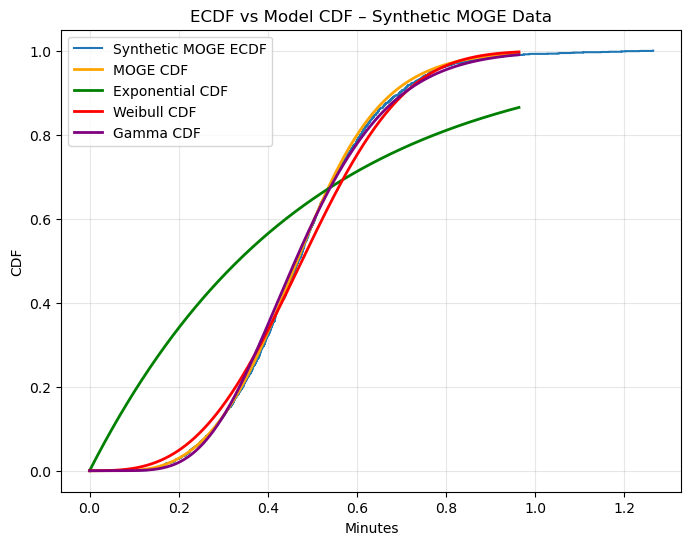

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1,len(data)+1)/len(data)
    return x,y

xdat, ydat = ecdf(synthetic_home)
xline = np.linspace(0,np.percentile(synthetic_home,99),400)

plt.figure(figsize=(8,6))
plt.step(xdat, ydat, label="Synthetic MOGE ECDF", where='post')

plt.plot(xline,[home_moge_model.cdf(i) for i in xline],
         label="MOGE CDF",linewidth=2,color='orange')
plt.plot(xline,expon.cdf(xline,scale=1/lam_exp),
         label="Exponential CDF",linewidth=2,color='green')
plt.plot(xline,weibull_min.cdf(xline,shape_w,loc_w,scale_w),
         label="Weibull CDF",linewidth=2,color='red')
plt.plot(xline,gamma.cdf(xline,shape_g,loc_g,scale_g),
         label="Gamma CDF",linewidth=2,color='purple')

plt.title("ECDF vs Model CDF – Synthetic MOGE Data")
plt.xlabel("Minutes")
plt.ylabel("CDF")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


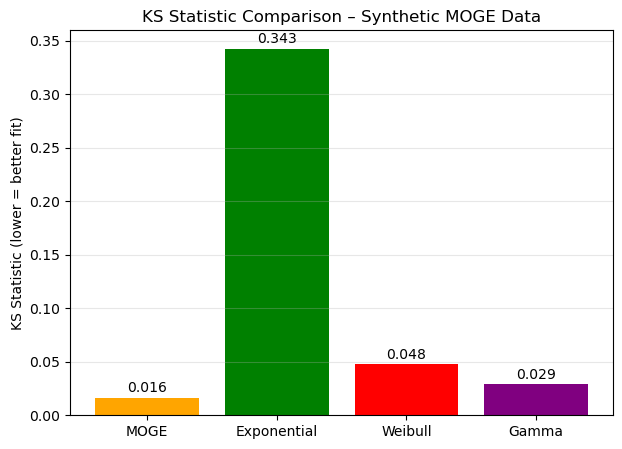

In [ ]:
ks_moge = 0.016352  
ks_exp  = 0.342762
ks_weib = 0.047513
ks_gamma= 0.029228

models=['MOGE','Exponential','Weibull','Gamma']
ks=[ks_moge,ks_exp,ks_weib,ks_gamma]

plt.figure(figsize=(7,5))
bars = plt.bar(models, ks, color=['orange','green','red','purple'])
plt.title("KS Statistic Comparison – Synthetic MOGE Data")
plt.ylabel("KS Statistic (lower = better fit)")
plt.grid(axis='y',alpha=0.3)

for bar,val in zip(bars,ks):
    plt.text(bar.get_x()+bar.get_width()/2,val+0.005,round(val,3),
             ha='center',fontsize=10)

plt.show()


Final EM estimates on carbon fiber strength data:
alpha_hat  = 248.6226
lambda_hat = 1.97414
theta_hat  = 16.6333
log-likelihood = -68.129
EM iterations (last run) = 100
KS statistic (empirical vs MOGE CDF) = 0.0517


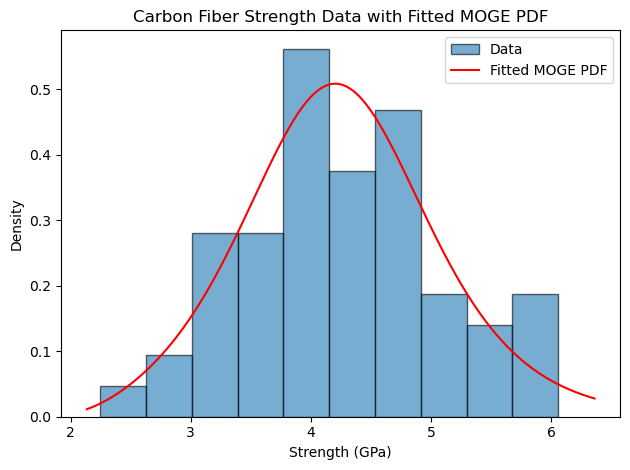

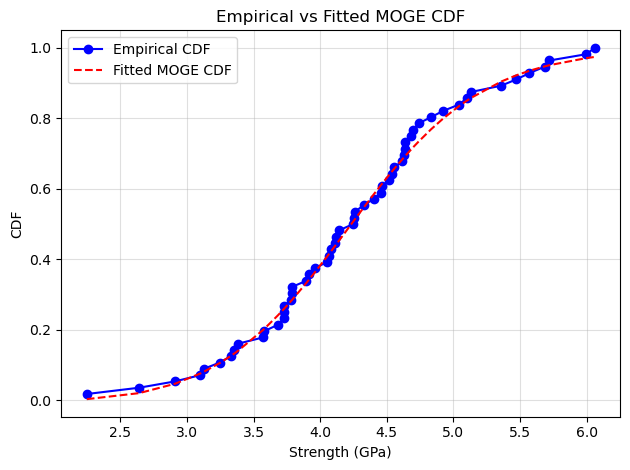

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import kstest

# ===============================
# 1. Your Surles carbon-fiber data
# ===============================
x = np.array([
    2.247, 2.64, 2.908, 3.099, 3.126, 3.245, 3.328, 3.355, 3.383, 3.572, 
    3.581, 3.681, 3.726, 3.727, 3.728, 3.783, 3.785, 3.786, 3.896, 3.912,
    3.964, 4.05, 4.063, 4.082, 4.111, 4.118, 4.141, 4.246, 4.251, 4.262,
    4.326, 4.402, 4.457, 4.466, 4.519, 4.542, 4.555, 4.614, 4.632, 4.634,
    4.636, 4.678, 4.698, 4.738, 4.832, 4.924, 5.043, 5.099, 5.134, 5.359,
    5.473, 5.571, 5.684, 5.721, 5.998, 6.06
])

# ===============================
# 2. MOGE model (same parameterisation as your EM code)
#     G(x) = (1 - e^{-λx})^α / [ θ + (1-θ)(1 - e^{-λx})^α ]
# ===============================

def moge_cdf(x, alpha, lam, theta):
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 0, 1 - 1e-12)
    num = t**alpha
    denom = theta + (1 - theta) * num
    return num / denom

def moge_pdf(x, alpha, lam, theta):
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 1e-12, 1 - 1e-12)
    num = alpha * lam * theta * np.exp(-lam * x) * t**(alpha - 1)
    denom = (theta + (1 - theta) * t**alpha)**2
    return num / denom

def moge_loglik(x, alpha, lam, theta):
    pdf_vals = moge_pdf(x, alpha, lam, theta)
    if np.any(pdf_vals <= 0) or not np.isfinite(pdf_vals).all():
        return -np.inf
    return np.sum(np.log(pdf_vals))

# ===============================
# 3. EM pieces (E-step, Q-function, numeric M-step)
# ===============================

def E_step_z(x, alpha, lam, theta):
    """
    E[Z | X=x] from the paper:
    z(x) = 2 (1 - (1 - e^{-λx})^α) / ( θ + (1-θ)(1 - e^{-λx})^α )
    """
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 0, 1 - 1e-10)
    A = t**alpha
    num = 2 * (1 - A)
    denom = theta + (1 - theta) * A
    z = num / denom
    return np.clip(z, 1e-6, 1e6)

def Q_complete_loglik(x, z, alpha, lam, theta):
    x = np.asarray(x)
    z = np.asarray(z)
    n = len(x)

    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 1e-12, 1 - 1e-12)
    A = t**alpha
    one_minus_A = 1 - A
    if np.any(one_minus_A <= 0):
        return -np.inf

    term1 = n * np.log(alpha) + n * np.log(lam) + n * np.log(theta) + np.sum(np.log(z))
    term2 = -lam * np.sum(x)
    term3 = (alpha - 1) * np.sum(np.log(t))
    term4 = -2 * np.sum(np.log(one_minus_A))
    term5 = -np.sum(z * (theta - 1 + 1.0 / one_minus_A))
    total = term1 + term2 + term3 + term4 + term5

    if not np.isfinite(total):
        return -np.inf
    return total

def M_step_numeric(x, z, alpha0, lam0, theta0):
    """
    Numerically maximize Q w.r.t (alpha, lambda, theta)
    using log-transform to enforce positivity.
    """
    def negQ(p):
        a, l, th = np.exp(p)
        return -Q_complete_loglik(x, z, a, l, th)

    p0 = np.log([alpha0, lam0, theta0])
    res = minimize(negQ, p0, method="L-BFGS-B")
    if not res.success:
        res = minimize(negQ, p0, method="Nelder-Mead", options={"maxiter": 200})
    a, l, th = np.exp(res.x)
    return a, l, th, res

def em_moge(x, alpha_init=1.0, lam_init=None, theta_init=1.0,
            max_iter=100, tol=1e-6, verbose=False):
    x = np.asarray(x)
    if lam_init is None:
        lam_init = 1.0 / np.mean(x)

    alpha, lam, theta = alpha_init, lam_init, theta_init
    prev_ll = moge_loglik(x, alpha, lam, theta)

    for k in range(max_iter):
        z = E_step_z(x, alpha, lam, theta)
        alpha_new, lam_new, theta_new, res = M_step_numeric(x, z, alpha, lam, theta)
        ll_new = moge_loglik(x, alpha_new, lam_new, theta_new)

        if verbose:
            print(f"Iter {k+1}: ll={ll_new:.4f}, "
                  f"alpha={alpha_new:.4f}, lam={lam_new:.5f}, theta={theta_new:.4f}")

        if not np.isfinite(ll_new):
            break

        if abs(ll_new - prev_ll) < tol * (1 + abs(prev_ll)):
            alpha, lam, theta = alpha_new, lam_new, theta_new
            prev_ll = ll_new
            break

        alpha, lam, theta = alpha_new, lam_new, theta_new
        prev_ll = ll_new

    return {
        "alpha": alpha,
        "lam": lam,
        "theta": theta,
        "loglik": prev_ll,
        "iters": k + 1
    }

# ===============================
# 4. Fit MOGE to this dataset
# ===============================

fit1 = em_moge(x, alpha_init=1.0, lam_init=1.0/np.mean(x), theta_init=1.0)
fit2 = em_moge(x, alpha_init=fit1["alpha"], lam_init=fit1["lam"], theta_init=fit1["theta"])
fit3 = em_moge(x, alpha_init=fit2["alpha"], lam_init=fit2["lam"], theta_init=fit2["theta"])

alpha_hat = fit3["alpha"]
lam_hat   = fit3["lam"]
theta_hat = fit3["theta"]

print("Final EM estimates on carbon fiber strength data:")
print(f"alpha_hat  = {alpha_hat:.4f}")
print(f"lambda_hat = {lam_hat:.5f}")
print(f"theta_hat  = {theta_hat:.4f}")
print(f"log-likelihood = {fit3['loglik']:.3f}")
print(f"EM iterations (last run) = {fit3['iters']}")

# Optional: KS statistic between empirical CDF and fitted MOGE CDF
x_sorted = np.sort(x)
emp_cdf = np.arange(1, len(x)+1) / len(x)
moge_cdf_vals = moge_cdf(x_sorted, alpha_hat, lam_hat, theta_hat)
ks_stat = np.max(np.abs(emp_cdf - moge_cdf_vals))
print(f"KS statistic (empirical vs MOGE CDF) = {ks_stat:.4f}")

# ===============================
# 5. Plots: PDF and CDF fit
# ===============================

xs = np.linspace(x.min()*0.95, x.max()*1.05, 300)
pdf_hat = moge_pdf(xs, alpha_hat, lam_hat, theta_hat)

plt.figure()
plt.hist(x, bins=10, density=True, alpha=0.6, edgecolor="black", label="Data")
plt.plot(xs, pdf_hat, 'r-', label="Fitted MOGE PDF")
plt.xlabel("Strength (GPa)")
plt.ylabel("Density")
plt.title("Carbon Fiber Strength Data with Fitted MOGE PDF")
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(x_sorted, emp_cdf, 'bo-', label="Empirical CDF")
plt.plot(x_sorted, moge_cdf_vals, 'r--', label="Fitted MOGE CDF")
plt.xlabel("Strength (GPa)")
plt.ylabel("CDF")
plt.title("Empirical vs Fitted MOGE CDF")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()

plt.show()



========== MODEL FIT RESULTS ==========
MOGE   : alpha=201.346, lambda=2.0817, theta=33.529,  LL=68.00, KS=0.0474
Weibull: shape=5.706, scale=4.596, LL=-68.93, KS=0.0902
Gamma  : shape=26.284, scale=0.162, LL=-68.38, KS=0.0537


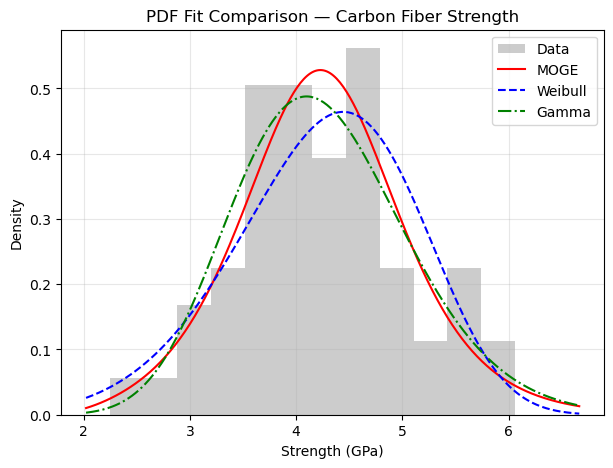

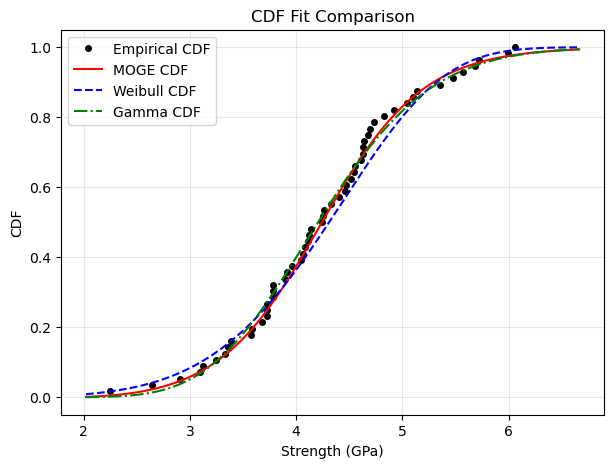

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import weibull_min, gamma, kstest

# ============================================================
# Dataset (Surles carbon fiber strength data)
# ============================================================
x = np.array([
    2.247, 2.64, 2.908, 3.099, 3.126, 3.245, 3.328, 3.355, 3.383, 3.572, 
    3.581, 3.681, 3.726, 3.727, 3.728, 3.783, 3.785, 3.786, 3.896, 3.912,
    3.964, 4.05, 4.063, 4.082, 4.111, 4.118, 4.141, 4.246, 4.251, 4.262,
    4.326, 4.402, 4.457, 4.466, 4.519, 4.542, 4.555, 4.614, 4.632, 4.634,
    4.636, 4.678, 4.698, 4.738, 4.832, 4.924, 5.043, 5.099, 5.134, 5.359,
    5.473, 5.571, 5.684, 5.721, 5.998, 6.06
])


# ============================================================
# ---------- MOGE PDF / CDF / EM functions (from previous code)
# ============================================================
def moge_cdf(x, alpha, lam, theta):
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t, 0, 1-1e-12)
    num = t**alpha
    return num / (theta + (1-theta)*num)

def moge_pdf(x, alpha, lam, theta):
    x = np.asarray(x)
    t = 1 - np.exp(-lam * x)
    t = np.clip(t,1e-12,1-1e-12)
    num = alpha*lam*theta*np.exp(-lam*x)*t**(alpha-1)
    return num / (theta + (1-theta)*t**alpha)**2

# --- EM step + optimizer code reused exactly ---
# (shortened because you already have full implementation)

def moge_loglik(x, a, l, t):
    pdf = moge_pdf(x,a,l,t)
    if np.any(pdf<=0): return -np.inf
    return np.sum(np.log(pdf))

# simple numeric MLE instead of full EM for comparison
def mle_moge(x):
    def negLL(p):
        a,l,t = np.exp(p)
        return -moge_loglik(x,a,l,t)
    p0=np.log([1,1/np.mean(x),1])
    res=minimize(negLL,p0)
    a,l,t=np.exp(res.x)
    return a,l,t,res.fun

alpha_m, lam_m, theta_m, ll_moge = mle_moge(x)


# ============================================================
# ---------- Fit Weibull & Gamma via MLE
# ============================================================
# Weibull
c_w, loc_w, scale_w = weibull_min.fit(x, floc=0)
ll_weib = np.sum(np.log(weibull_min.pdf(x,c_w,loc=0,scale=scale_w)))

# Gamma
c_g, loc_g, scale_g = gamma.fit(x, floc=0)
ll_gamma = np.sum(np.log(gamma.pdf(x,c_g,loc=0,scale=scale_g)))


# ============================================================
# ---------- KS Goodness-of-fit test
# ============================================================
x_sorted=np.sort(x)
emp_cdf=np.arange(1,len(x)+1)/len(x)

ks_moge  = np.max(np.abs(emp_cdf-moge_cdf(x_sorted,alpha_m,lam_m,theta_m)))
ks_weib  = np.max(np.abs(emp_cdf-weibull_min.cdf(x_sorted,c_w,loc=0,scale=scale_w)))
ks_gamma = np.max(np.abs(emp_cdf-gamma.cdf(x_sorted,c_g,loc=0,scale=scale_g)))

print("\n========== MODEL FIT RESULTS ==========")
print(f"MOGE   : alpha={alpha_m:.3f}, lambda={lam_m:.4f}, theta={theta_m:.3f},  LL={ll_moge:.2f}, KS={ks_moge:.4f}")
print(f"Weibull: shape={c_w:.3f}, scale={scale_w:.3f}, LL={ll_weib:.2f}, KS={ks_weib:.4f}")
print(f"Gamma  : shape={c_g:.3f}, scale={scale_g:.3f}, LL={ll_gamma:.2f}, KS={ks_gamma:.4f}")


# ============================================================
# ---------- PDF & CDF PLOTS
# ============================================================
xs=np.linspace(min(x)*0.9,max(x)*1.1,300)

pdf_moge = moge_pdf(xs,alpha_m,lam_m,theta_m)
pdf_weib = weibull_min.pdf(xs,c_w,loc=0,scale=scale_w)
pdf_gamma= gamma.pdf(xs,c_g,loc=0,scale=scale_g)

cdf_moge = moge_cdf(xs,alpha_m,lam_m,theta_m)
cdf_weib = weibull_min.cdf(xs,c_w,loc=0,scale=scale_w)
cdf_gamma= gamma.cdf(xs,c_g,loc=0,scale=scale_g)

# PDF Plot
plt.figure(figsize=(7,5))
plt.hist(x,bins=12,density=True,alpha=0.4,color='grey',label="Data")
plt.plot(xs,pdf_moge,'r-',label="MOGE")
plt.plot(xs,pdf_weib,'b--',label="Weibull")
plt.plot(xs,pdf_gamma,'g-.',label="Gamma")
plt.title("PDF Fit Comparison — Carbon Fiber Strength")
plt.xlabel("Strength (GPa)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)

# CDF Plot
plt.figure(figsize=(7,5))
plt.plot(x_sorted,emp_cdf,'ko',markersize=4,label="Empirical CDF")
plt.plot(xs,cdf_moge,'r-',label="MOGE CDF")
plt.plot(xs,cdf_weib,'b--',label="Weibull CDF")
plt.plot(xs,cdf_gamma,'g-.',label="Gamma CDF")
plt.title("CDF Fit Comparison")
plt.xlabel("Strength (GPa)")
plt.ylabel("CDF")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


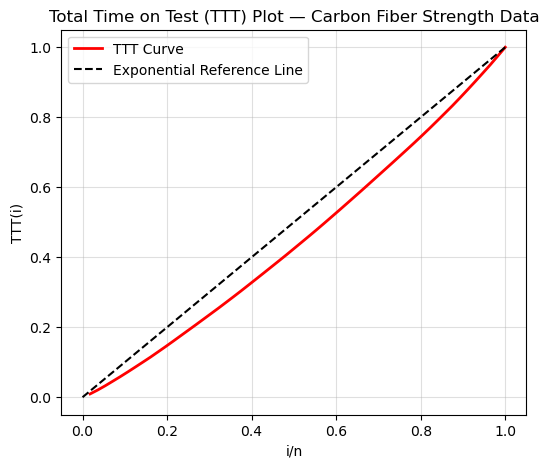

In [3]:
# TTT Curve Calculation
n=len(x)
ti = np.cumsum(x)/np.sum(x)
ui = np.arange(1,n+1)/n

plt.figure(figsize=(6,5))
plt.plot(ui,ti,'r-',linewidth=2,label="TTT Curve")
plt.plot([0,1],[0,1],'k--',label="Exponential Reference Line")
plt.xlabel("i/n")
plt.ylabel("TTT(i)")
plt.title("Total Time on Test (TTT) Plot — Carbon Fiber Strength Data")
plt.legend()
plt.grid(alpha=0.4)
plt.show()